In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# !gdown --folder https://drive.google.com/drive/folders/1dqD8P_JEsM6vB3Ywsjaw-5IW8agK4YxZ

In [4]:
# !git pull https://github.com/Lily-XueCY/cliport.git

## OFA

In [5]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [6]:
# cd ..

In [7]:
from OFA_VQA.core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset, VqaStackDataset

from OFA_VQA.core.ofa.modeling_ofa import OFAModelForVQA
from OFA_VQA.core.ofa import OFATokenizer
from OFA_VQA.core.ofa.configuration_ofa import OFAConfig

from PIL import Image
from torchvision import transforms


## OpenAI

In [8]:
import openai

In [9]:
import os
import sys
import json
import hydra
import random

import numpy as np
import torch
import cv2
from cliport.dataset import RavensDataset
from cliport.tasks import cameras
from cliport.tasks import primitives
from cliport.tasks.grippers import Suction
from cliport.tasks.task import Task

from cliport import agents
from cliport import dataset
from cliport import tasks
from cliport.utils import utils
from cliport.environments.environment import Environment

import pybullet as p

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

oracle_cams = cameras.Oracle.CONFIG
# Workspace bounds.
pix_size = 0.003125
bounds = np.array([[0.25, 0.75], [-0.4, 0.4], [0, 0.3]])

In [10]:
class VLM():
    def __init__(self , model_path = '/coc/scratch/sanisetty3/DLM/huggingface/ofa-vqa-base/'):
        
        self.model_path = model_path
        self.tokenizer = OFATokenizer.from_pretrained(self.model_path)
        self.model = OFAModelForVQA.from_pretrained(self.model_path, use_cache=False).cuda().eval()
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        
        self.resolution = 480
        self.patch_resize_transform = transforms.Compose([
            lambda image: image.convert("RGB"),
            transforms.Resize((self.resolution , self.resolution ), interpolation=Image.BICUBIC),
            transforms.ToTensor(), 
            transforms.Normalize(mean=mean, std=std)
        ])
        vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/images/*.png"
        self.img_list = glob(vqa_root)
        
    @torch.no_grad()
    def get_top_block(self, block_color , img):
        """
        get colour of the block above block_color input. returns None if nothing is present
        
        """
        
        img = self.conver2yellow(img)
        
        question = f"Are there any blocks on top of the {block_color} block?"
        inputs = self.tokenizer([question], return_tensors="pt").input_ids
        patch_img = self.patch_resize_transform(img).unsqueeze(0)
        custom_gen_fin = self.model.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)
        answer = self.tokenizer.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip()
        
        if answer.lower() == "no":
            return None
        else:
        
            question = f"What color is the block on top of the {block_color} block?"
            inputs = self.tokenizer([question], return_tensors="pt").input_ids
            patch_img = self.patch_resize_transform(img).unsqueeze(0)
            custom_gen_fin = self.model.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)
            answer = self.tokenizer.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip()
                       
            return answer.lower()
        
    @torch.no_grad()
    def get_bowl_block(self, bowl_color , img):
        
        """
        get colour of the block inside bowl_color input. returns None if nothing is present
        
        """
        img = self.conver2yellow(img)
        
        question = f"Are there any blocks inside the {bowl_color} bowl?"
        inputs = self.tokenizer([question], return_tensors="pt").input_ids
        patch_img = self.patch_resize_transform(img).unsqueeze(0)
        custom_gen_fin = self.model.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)
        answer = self.tokenizer.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip()
        
        if answer.lower() == "no":
            return None
        else:
        
            question = f"What color is the block inside the {bowl_color} bowl?"
            inputs = self.tokenizer([question], return_tensors="pt").input_ids
            patch_img = self.patch_resize_transform(img).unsqueeze(0)
            custom_gen_fin = self.model.generate(inputs.cuda(), patch_images=patch_img.cuda(), num_beams=5, no_repeat_ngram_size=3)
            answer = self.tokenizer.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip()
                       
            return answer.lower()

        
    # def get_image(self):
        
    #     img = Image.open(img_list[101])
    #     return img
    
    def conver2yellow(self,img):
    
        img_ = np.array(img)
        r1, g1, b1 = 239, 239, 239 # Original value
        r2, g2, b2 = 188, 140, 33 # Value that we want to replace it with

        red, green, blue = img_[:,:,0], img_[:,:,1], img_[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        img_[:,:,:3][mask] = [r2, g2, b2]

        r1, g1, b1 = 222, 222, 222 # Original value
        red, green, blue = img_[:,:,0], img_[:,:,1], img_[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        img_[:,:,:3][mask] = [r2, g2, b2]
    

        return Image.fromarray(img_)
    
    def get_block(self,block):
        return str(block).lower()
    
    def get_bowl(self,bowl):
        return str(bowl).lower()

In [11]:
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/bowl_place/images/*.png"
img_list = glob(vqa_root)

In [12]:
finetuned_sb = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-mix/'

finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/'


In [13]:
vlm =VLM(finetuned)

/coc/scratch/sanisetty3/DLM/ofa-base-vqa-bowl/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


pybullet build time: Apr 19 2023 10:27:14


/srv/share2/sanisetty3/miniconda3/envs/cliport/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


cyan


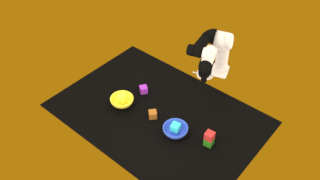

In [14]:
img = Image.open(img_list[11]).convert("RGB")
print(vlm.get_bowl_block("blue" , (img)))
img

In [16]:
def setup_environment(object_list, disp=False):
    env = Environment(
        '/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/',
        disp=disp,
        shared_memory=False,
        hz=480,
        # record_cfg=cfg['record']
    )
    env.seed(0)
    task = GeneralTask()
    env.set_task(task)
    obs = env.reset()
    lang_objects = object_list
    colors = []

    n_bowls = 0
    bowl_size = (0.14, 0.14, 0)
    bowl_urdf = 'bowl/bowl.urdf'

    n_blocks = 0
    block_size = (0.04, 0.04, 0.04)
    block_urdf = 'stacking/block.urdf'
    objects = {}

    for obj in lang_objects:
        print(obj)
        color_name, item = obj.split(' ')
        color = utils.COLORS[color_name]
        colors.append(color)
        if item == 'block':
            n_blocks += 1
            block_pose = get_random_pose(env, block_size)
            if block_pose == (None, None):
                block_pose = get_random_pose(env, block_size)
            print(block_pose)
            block_id = env.add_object(block_urdf, block_pose)
            p.changeVisualShape(block_id, -1, rgbaColor=color + [1])
            objects[obj] = block_id
        if item == 'bowl':
            n_bowls += 1
            bowl_pose = get_random_pose(env, bowl_size)
            bowl_id = env.add_object(bowl_urdf, bowl_pose)
            p.changeVisualShape(bowl_id, -1, rgbaColor=color + [1])
            objects[obj] = bowl_id
#         input("Enter to continue")

    return env, task, obs, objects

In [17]:
class GeneralTask(Task):
    def __init__(self):
        super().__init__()
        self.max_steps = 12
        self.lang_template = "put the {pick} on a {place}"
        self.task_completed_desc = "done."

    def reset(self, env):
        super().reset(env)

    def set_goals(self, env, lines, obj_info):
    # objs, matches, targs, _, _, metric, params, max_reward = goals
    # object_id, (symmetry, _) = objs[i]
        self.goals = []
        self.lang_goals = []
        for line in lines:
            self.goals.append(([(0, (np.pi / 2, None))],
                               np.ones((1, 1)),
                               [],
                               False, True, 'pose', None, 1))
            self.lang_goals.append(line)

    def get_colors(self):
        return utils.TRAIN_COLORS if self.mode == 'train' else utils.EVAL_COLORS
    
    def reward(self):
        # self.goals.pop(0)
        # if len(self.lang_goals) > 0:
        #     self.lang_goals.pop(0)
        return (0, {})
    
    def done(self):
        return (len(self.goals) == 0)


def get_true_image(env):
    """Get RGB-D orthographic heightmaps and segmentation masks."""
    # Capture near-orthographic RGB-D images and segmentation masks.
    color, depth, segm = env.render_camera(oracle_cams[0])

    # Combine color with masks for faster processing.
    color = np.concatenate((color, segm[Ellipsis, None]), axis=2)

    # Reconstruct real orthographic projection from point clouds.
    hmaps, cmaps = utils.reconstruct_heightmaps(
        [color], [depth], oracle_cams, bounds, pix_size)

    # Split color back into color and masks.
    cmap = np.uint8(cmaps)[0, Ellipsis, :3]
    hmap = np.float32(hmaps)[0, Ellipsis]
    mask = np.int32(cmaps)[0, Ellipsis, 3:].squeeze()
    return cmap, hmap, mask


def get_random_pose(env, obj_size):
    """Get random collision-free object pose within workspace bounds."""

    # Get erosion size of object in pixels.
    max_size = np.sqrt(obj_size[0] ** 2 + obj_size[1] ** 2)
    erode_size = int(np.round(max_size / pix_size))

    _, hmap, obj_mask = get_true_image(env)

    # Randomly sample an object pose within free-space pixels.
    free = np.ones(obj_mask.shape, dtype=np.uint8)
    for obj_ids in env.obj_ids.values():
        for obj_id in obj_ids:
            free[obj_mask == obj_id] = 0
    free[0, :], free[:, 0], free[-1, :], free[:, -1] = 0, 0, 0, 0
    free = cv2.erode(free, np.ones((erode_size, erode_size), np.uint8))
    if np.sum(free) == 0:
        return None, None
    pix = utils.sample_distribution(np.float32(free))
    pos = utils.pix_to_xyz(pix, hmap, bounds, pix_size)
    pos = (pos[0], pos[1], obj_size[2] / 2)
    theta = np.random.rand() * 2 * np.pi
    rot = utils.eulerXYZ_to_quatXYZW((0, 0, theta))
    return pos, rot

In [197]:
class Robot():
    def __init__(self , model_file_name = 'steps=120000-val_loss=0.00014955.ckpt'):
        
        utils.set_seed(0, torch=True)

        
        self.objects = ["red block"  , "yellow block" , "green block", "green bowl", "red bowl", "yellow bowl"]
        tcfg = utils.load_hydra_config(vcfg['train_config'])

        # Initialize environment and task.
        self.env, self.task, self.obs, self.obj_info = self.setup_environment(object_list=self.objects, disp=False)
        print("initialised environment")
        plt.imshow(self.obs['color'][0])
        plt.show()

        # Choose eval mode and task.
        self.mode = vcfg['mode']
        eval_task = vcfg['eval_task']
        dataset_type = vcfg['type']
        
        # Load model
        
        self.name = f"{eval_task}-{vcfg['agent']}-n{vcfg['n_demos']}"
        model_file = os.path.join(vcfg['model_path'], model_file_name)
        
        self.agent = agents.names[vcfg['agent']](self.name, tcfg, None, None)
        self.agent.load(model_file)
        print(f"Loaded: {model_file}")
        
        

        
        
        self.lang_goals = ''
        
    def get_object_names(self):
#         global objects
        return self.objects
    def put_first_on_second(self,obj1, obj2):
#         global lang_goals
        print(obj1, obj2)
        self.lang_goals += ['place(\'{}\',\'{}\')\n'.format(obj1, obj2)]
        
    def load_task(self , lang_goals = ''):
        self.lang_goals = lang_goals
        seed = 42
        
        np.random.seed(seed)

        task_name = vcfg['eval_task']
        self.task.set_goals(self.env, self.lang_goals, self.obj_info)
        self.task.mode = self.mode
        self.env.seed(seed)
        self.env.set_task(self.task)
        self.info = self.env.info
#         self.reward = 0

        self.total_reward = 0
    
    def reset(self):
        self.env, self.task, self.obs, self.obj_info = self.setup_environment(object_list=self.objects, disp=False)
        self.lang_goals = ""
        print("resetting environment")
        plt.imshow(self.obs['color'][0])
        plt.show()
    
    def conver2yellow(self,img):
    
        img_ = np.array(img)
        r1, g1, b1 = 239, 239, 239 # Original value
        r2, g2, b2 = 188, 140, 33 # Value that we want to replace it with

        red, green, blue = img_[:,:,0], img_[:,:,1], img_[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        img_[:,:,:3][mask] = [r2, g2, b2]

        r1, g1, b1 = 222, 222, 222 # Original value
        red, green, blue = img_[:,:,0], img_[:,:,1], img_[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        img_[:,:,:3][mask] = [r2, g2, b2]
    

        return Image.fromarray(img_)
    
    def execute_step(self, vlm_question, src,trg, max_iters = 10):
        
        
        for _ in range(max_iters):
#             print("task", self.task.lang_goals)
            
            act = self.agent.act(self.obs, self.info , None)
            lang_goal = self.info['lang_goal']
            print(f'Lang Goal: {lang_goal}')
            self.obs, reward, done, self.info  = self.env.step(act)
            
            self.total_reward += reward
#             print(f'Total Reward: {self.total_reward:.3f} | Done: {done}\n')
            
            print("new observation")
            
            plt.imshow(self.conver2yellow(self.obs['color'][0]))
            plt.show()

            if lang_goal == "":
                success = False
            else:
                ans = vlm_question(trg , (Image.fromarray(self.obs['color'][0]))) 
                print(f"question: What colour block is in the {trg} bowl? ,vlm answer" , ans)
                if ans is None:
                    success = False
                elif ans in src:
                    success = True
#                     break
                else:
                    success = False


#             print("success: ",success)
            if success: #success
                lang_goal = self.lang_goals.pop(0)
                if len(self.lang_goals) > 0:
#                     print(self.lang_goals)
                    
#                     print("completed : " , lang_goal, "next: ",self.lang_goals)
                    self.task.set_goals(self.env, self.lang_goals, self.obj_info)
#                     print("task", self.task.lang_goals)
                else:
                    break
            else:
#                 print("task failed, lang_goals",self.lang_goals)
                self.task.set_goals(self.env, self.lang_goals, self.obj_info)

#             plt.imshow(self.obs['color'][0])
#             plt.show()


        

        
    def get_img(self):
        return Image.fromarray(self.obs['color'][0])
        
        
    def setup_environment(self, object_list, disp=False):
        env = Environment(
            '/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/',
            disp=disp,
            shared_memory=False,
            hz=480,
            # record_cfg=cfg['record']
        )
        env.seed(0)
        task = GeneralTask()
        env.set_task(task)
        obs = env.reset()
        lang_objects = object_list
        colors = []

        n_bowls = 0
        bowl_size = (0.15, 0.15, 0)
        bowl_urdf = 'bowl/bowl.urdf'

        n_blocks = 0
        block_size = (0.04, 0.04, 0.04)
        block_urdf = 'stacking/block.urdf'
        objects = {}

        for obj in lang_objects:
            print(obj)
            color_name, item = obj.split(' ')
            color = utils.COLORS[color_name]
            colors.append(color)
            if item == 'block':
                n_blocks += 1
                block_pose = get_random_pose(env, block_size)
                if block_pose == (None, None):
                    block_pose = get_random_pose(env, block_size)
                print(block_pose)
                block_id = env.add_object(block_urdf, block_pose)
                p.changeVisualShape(block_id, -1, rgbaColor=color + [1])
                objects[obj] = block_id
            if item == 'bowl':
                n_bowls += 1
                bowl_pose = get_random_pose(env, bowl_size)
                bowl_id = env.add_object(bowl_urdf, bowl_pose)
                p.changeVisualShape(bowl_id, -1, rgbaColor=color + [1])
                objects[obj] = bowl_id
    #         input("Enter to continue")

        return env, task, obs, objects
        


In [19]:
vcfg = {
    'mode': 'test',
    'eval_task': 'put-block-in-bowl-seen-colors',
    'type': 'single',
    'data_dir': '/srv/scratch/sanisetty3/DLM/cliport/data',
    'n_demos': 1,
    'agent': 'cliport',
    'model_path':    '/coc/scratch/sanisetty3/DLM/cliport/exp/multi-language-conditioned-cliport-n1000-train/checkpoints/',
    'save_path':'/coc/scratch/sanisetty3/DLM/cliport/exp/put-block-in-bowl-seen-colors-cliport-n1000-train/checkpoints/',
    'update_results': True,
    'n_repeats': 1,
    'save_results': False,
    'train_config': '/coc/scratch/sanisetty3/DLM/cliport/exp/multi-language-conditioned-cliport-n1000-train/.hydra/config.yaml'
    
       }

# CLIPORT OFA LLM

In [20]:
def find_object_related_to_obj(pos, obj):
    """
     Arguments are direction and and object and it returns the object that is in relation with object. 
     Example, find_obj_related_to_obj(’left’,’red block’) returns the object that is left of red block.
     The allowed values for relation are : left of, above, below, on top, right of, inside
    """
    if pos in ["below" , "inside"]:
        return vlm.get_bowl_block(obj.split(" ")[0],Image.fromarray(robot.obs['color'][0]))
    if pos in ["on top" , "above"]:
        return vlm.get_top_block(obj.split(" ")[0],Image.fromarray(robot.obs['color'][0]))

In [21]:
def put_first_on_second(block, matching_bowl):
    lang_goals = [f"place the {block} in a {matching_bowl}"]
    robot.load_task(lang_goals)
    robot.execute_step(vlm.get_bowl_block, src = block.split(" ")[0], trg =matching_bowl.split(" ")[0] ,max_iters=1)
    

In [22]:
def tell_planner(msg):
    print(msg)

In [23]:

def get_object_names():
    return objects



# Mismatch 

text argument:/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/
int args: [red block
((0.30625, 0.03749999999999998, 0.02), (0.0, -0.0, 0.7800583048932599, -0.6257068330832372))
yellow block
((0.34375, 0.08437499999999998, 0.02), (0.0, -0.0, 0.9900753005916922, -0.1405378922507032))
green block
((0.48125, -0.07187500000000002, 0.02), (0.0, -0.0, 0.8967882722968328, -0.44245993566746994))
green bowl
red bowl
yellow bowl
initialised environment


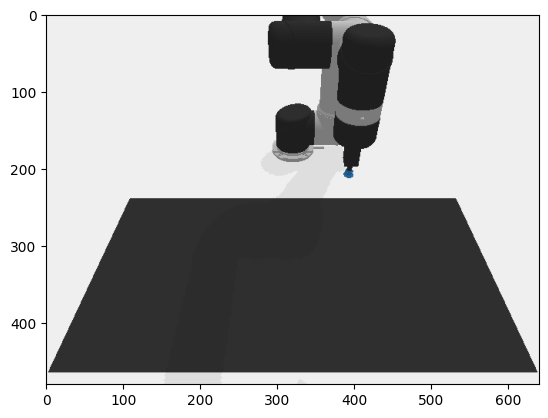

Attn FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: add
Transport FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: conv
Agent: put-block-in-bowl-seen-colors-cliport-n1, Logging: False
Loaded: /coc/scratch/sanisetty3/DLM/cliport/exp/multi-language-conditioned-cliport-n1000-train/checkpoints/steps=120000-val_loss=0.00014955.ckpt


In [296]:
bounds = np.array([[0.25, 0.7], [-0.4, 0.4], [0, 0.3]])
robot = Robot()        


In [297]:
total_block = [ "green block","blue block", "yellow block", "red block" , "gray block" , "brown block"]
total_bowl = [ "green bowl","blue bowl", "yellow bowl", "red bowl" , "gray bowl" , "brown bowl"]




['red block',
 'green block',
 'yellow block',
 'red bowl',
 'brown bowl',
 'yellow bowl',
 'blue bowl']

In [299]:
objects = random.sample(total_block , random.randint(2,4)) + random.sample(total_bowl , random.randint(2,4))
robot.objects = objects


In [300]:
def validate_current_actions():
    invalid_actions = []
    if len(executed_actions) == 0:
        return []
    
    action = executed_actions[-1]
    index = len(executed_actions) - 1
    if action['type'] == 'put_first_inside_second':
        obj_a = action['obj_a']
        obj_b = action['obj_b']
        current_obj_inside = find_object_related_to_obj('inside', obj_b)
        print(f"current_obj_inside {obj_b}:", current_obj_inside , "target object: " , obj_a, str(current_obj_inside) in obj_a)

        if obj_a == "blue":
            obj_a = [obj_a , "gray"]
            
        if str(current_obj_inside) not in obj_a:
            invalid_actions.append((index, action))
                
            
    return invalid_actions


In [97]:
## curr valid 4/10
## prev valid 6/10

text argument:/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/
int args: [gray block
((0.578125, -0.09375, 0.02), (0.0, -0.0, 0.1542176413437417, -0.9880369016885822))
green block
((0.55, 0.17812499999999998, 0.02), (0.0, -0.0, 0.9523504170755709, -0.30500603780251007))
red block
((0.421875, -0.2625, 0.02), (0.0, 0.0, 0.4706887435654713, 0.8822993294119394))
brown bowl
yellow bowl
blue bowl
green bowl
resetting environment


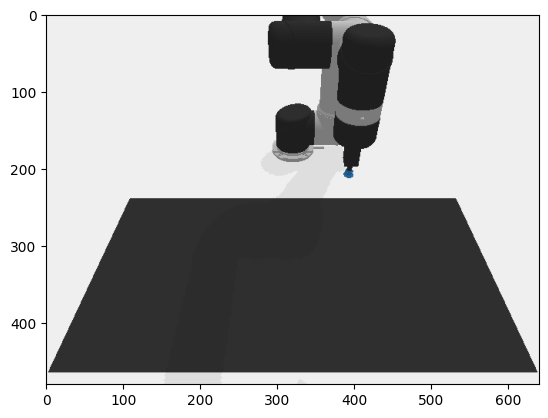

Lang Goal: place the gray block in a brown bowl
new observation


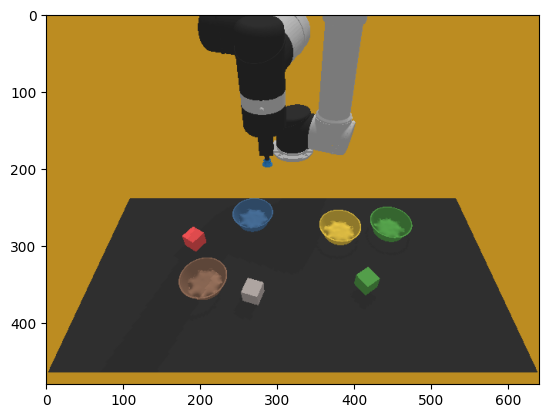

question: What colour block is in the brown bowl? ,vlm answer brown
Put the gray block in the brown bowl.
current_obj_inside brown bowl: brown target object:  gray block False
Validation failed. Action 0: put_first_inside_second(gray block, brown bowl) is no longer valid. Redoing the action.
Lang Goal: place the gray block in a brown bowl
new observation


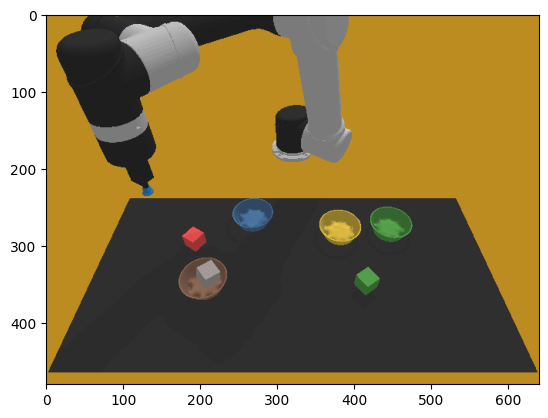

question: What colour block is in the brown bowl? ,vlm answer gray
current_obj_inside brown bowl: gray target object:  gray block True
Lang Goal: place the green block in a yellow bowl
new observation


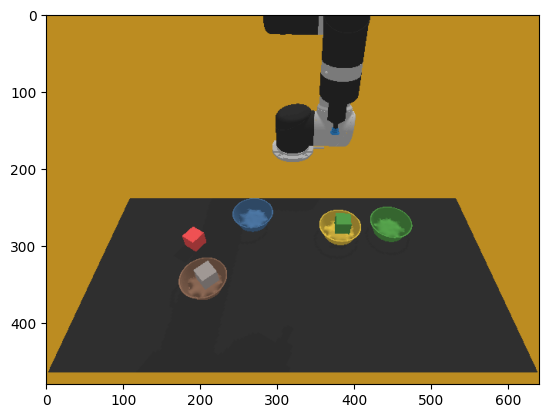

question: What colour block is in the yellow bowl? ,vlm answer green
Put the green block in the yellow bowl.
current_obj_inside brown bowl: red target object:  gray block False
current_obj_inside yellow bowl: green target object:  green block True
Validation failed. Action 0: put_first_inside_second(gray block, brown bowl) is no longer valid. Redoing the action.
Lang Goal: place the gray block in a brown bowl
new observation


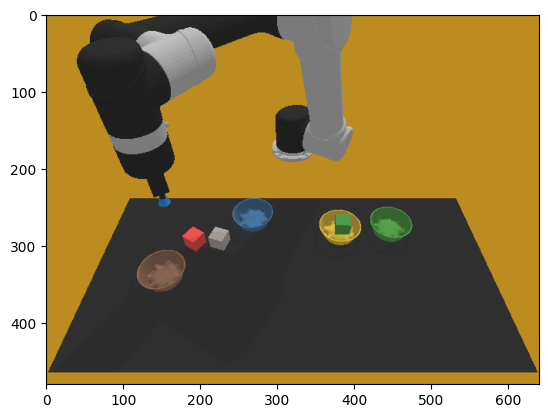

question: What colour block is in the brown bowl? ,vlm answer brown
current_obj_inside brown bowl: brown target object:  gray block False
current_obj_inside yellow bowl: green target object:  green block True
Validation failed. Action 0: put_first_inside_second(gray block, brown bowl) is no longer valid. Redoing the action.
Lang Goal: place the gray block in a brown bowl
new observation


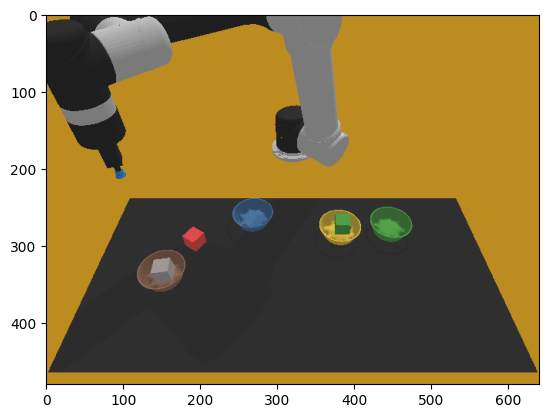

question: What colour block is in the brown bowl? ,vlm answer gray
current_obj_inside brown bowl: gray target object:  gray block True
current_obj_inside yellow bowl: green target object:  green block True
Lang Goal: place the red block in a blue bowl
new observation


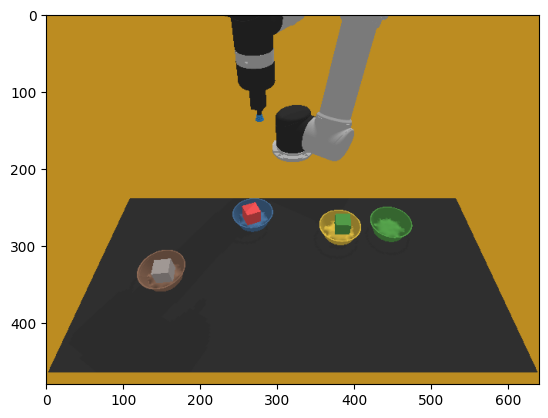

question: What colour block is in the blue bowl? ,vlm answer red
Put the red block in the blue bowl.
Plan Completed.


In [313]:

# List to track executed control actions
executed_actions = []
def validate_previous_actions():
    invalid_actions = []
    for index, action in enumerate(executed_actions):
        if action['type'] == 'put_first_inside_second':
            obj_a = action['obj_a']
            obj_b = action['obj_b']
            current_obj_inside = find_object_related_to_obj('inside', obj_b)
            print(f"current_obj_inside {obj_b}:", current_obj_inside , "target object: " , obj_a, str(current_obj_inside) in obj_a)

#             if obj_a.split(" ")[0] == "yellow":
#                 obj_a = [obj_a.split(" ")[0] , "brown"]

            if obj_a.split(" ")[0] == "blue":
                obj_a = [obj_a.split(" ")[0] , "gray"]
                
            if str(current_obj_inside) not in obj_a:
                invalid_actions.append((index, action))
                
            
    return invalid_actions

objects = random.sample(total_block , random.randint(2,4)) + random.sample(total_bowl , random.randint(2,4))
robot.objects = objects

# Get all objects on table
objects = get_object_names()
# Filter out the blocks and bowls
blocks = [obj for obj in objects if 'block' in obj]
bowls = [obj for obj in objects if 'bowl' in obj]
# Function to find a mismatched colored bowl for a given block

robot.reset()
executed_actions = []


def find_mismatched_bowl(block_color, remaining_bowls):
    for bowl in remaining_bowls:
        bowl_color = bowl.split(' ')[0]
        if block_color != bowl_color:
            return bowl
    return None

# Iterate through each block and find a mismatched colored bowl
for block in blocks:
    block_color = block.split(' ')[0]
    mismatched_bowl = find_mismatched_bowl(block_color, bowls)
    while True:
        # Check if previous actions are still valid
        invalid_actions = validate_previous_actions()
        if not invalid_actions:
            # If a mismatched colored bowl is found, put the block in the bowl
            if mismatched_bowl is not None:
                put_first_on_second(block, mismatched_bowl)
                executed_actions.append({
                    'type': 'put_first_inside_second',
                    'obj_a': block,
                    'obj_b': mismatched_bowl
                })
                print(f"Put the {block} in the {mismatched_bowl}.")
                # Remove the bowl from the list of available bowls
                bowls.remove(mismatched_bowl)
            else:
                tell_planner(f"No mismatched colored bowl found for the {block}.")
            break
        else:
            for index, invalid_action in invalid_actions:
                tell_planner(f"Validation failed. Action {index}: {invalid_action['type']}({invalid_action['obj_a']}, {invalid_action['obj_b']}) is no longer valid. Redoing the action.")
                # Redo the invalid action
                put_first_on_second(invalid_action['obj_a'], invalid_action['obj_b'])
tell_planner("Plan Completed.")

## Matching

text argument:/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/
int args: [red block
((0.34375, 5.551115123125783e-17, 0.02), (0.0, -0.0, 0.7800583048932599, -0.6257068330832372))
yellow block
((0.465625, 0.031250000000000056, 0.02), (0.0, -0.0, 0.9900753005916922, -0.1405378922507032))
green block
((0.559375, -0.08437499999999998, 0.02), (0.0, -0.0, 0.8967882722968328, -0.44245993566746994))
green bowl
red bowl
yellow bowl
initialised environment


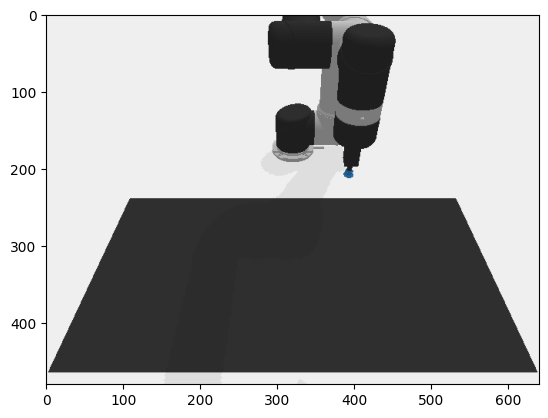

Attn FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: add
Transport FCN - Stream One: plain_resnet_lat, Stream Two: clip_lingunet_lat, Stream Fusion: conv
Agent: put-block-in-bowl-seen-colors-cliport-n1, Logging: False
Loaded: /coc/scratch/sanisetty3/DLM/cliport/exp/multi-language-conditioned-cliport-n1000-train/checkpoints/steps=120000-val_loss=0.00014955.ckpt


In [156]:
bounds = np.array([[0.25, 0.7], [-0.3, 0.25], [0, 0.3]])
robot = Robot()        


In [249]:
##curr : 4/12
##prev : 6/12

In [ ]:
##same col
##curr 3/12
##prev:2/10

In [282]:
total_block = [ "green block","blue block", "yellow block", "red block"]
total_bowl = [ "green bowl","blue bowl", "yellow bowl", "red bowl"]



In [ ]:
executed_actions = []
def validate_previous_actions():
    invalid_actions = []
    for index, action in enumerate(executed_actions):
        if action['type'] == 'put_first_inside_second':
            obj_a = action['obj_a']
            obj_b = action['obj_b']
            current_obj_inside = find_object_related_to_obj('inside', obj_b)
            print(f"current_obj_inside {obj_b}:", current_obj_inside , "target object: " , obj_a, str(current_obj_inside) in obj_a)

#             if obj_a.split(" ")[0] == "yellow":
#                 obj_a = [obj_a.split(" ")[0] , "brown"]

            if obj_a.split(" ")[0] == "blue":
                obj_a = [obj_a.split(" ")[0] , "gray"]
                
            if str(current_obj_inside) not in obj_a:
                invalid_actions.append((index, action))
                
            
    return invalid_actions

objects = random.sample(total_block , random.randint(3,3)) + random.sample(total_bowl , random.randint(3,3))
robot.objects = objects

# Get all objects on table
objects = get_object_names()
# Filter out the blocks and bowls
blocks = [obj for obj in objects if 'block' in obj]
bowls = [obj for obj in objects if 'bowl' in obj]
# Function to find a mismatched colored bowl for a given block

robot.reset()
executed_actions = []


for block in blocks:
    block_color = block.split(' ')[0]
    matching_bowl = None
    # Find the bowl with the same color as the block
    for bowl in bowls:
        bowl_color = bowl.split(' ')[0]
        if block_color.split("_")[0] in bowl_color:
            matching_bowl = bowl
            break
    while True:
        
        # Check if previous actions are still valid
        invalid_actions = validate_current_actions()
        if not invalid_actions:
            # If a matching colored bowl is found, put the block in the bowl
            if matching_bowl is not None:
                put_first_on_second(block, matching_bowl)
                executed_actions.append({
                    'type': 'put_first_inside_second',
                    'obj_a': block,
                    'obj_b': matching_bowl
                })
                print(f"Put the {block} in the {matching_bowl}.")
            else:
                tell_planner(f"No matching colored bowl found for the {block}.")
            break
        else:
            for index, invalid_action in invalid_actions:
                tell_planner(f"Validation failed. Action {index}: {invalid_action['type']}({invalid_action['obj_a']}, {invalid_action['obj_b']}) is no longer valid. Redoing the action.")
                # Redo the invalid action
                put_first_on_second(invalid_action['obj_a'], invalid_action['obj_b'])
tell_planner("Plan Completed.")

In [ ]:
# Image.fromarray(robot.obs["color"][0])

### No feedback

In [107]:
## 0/15

text argument:/coc/scratch/sanisetty3/DLM/cliport/cliport/environments/assets/
int args: [red block
((0.37812500000000004, -0.234375, 0.02), (0.0, -0.0, 0.159891581708253, -0.987134581553515))
brown block
((0.396875, 0.253125, 0.02), (0.0, -0.0, 0.5662404867954776, -0.8242400809919526))
gray block
((0.659375, -0.09687499999999999, 0.02), (0.0, 0.0, 0.30205346004500816, 0.9532909877234961))
green block
((0.490625, 0.10000000000000003, 0.02), (0.0, 0.0, 0.9823769073705791, 0.18691070559231396))
brown bowl
gray bowl
red bowl
resetting environment


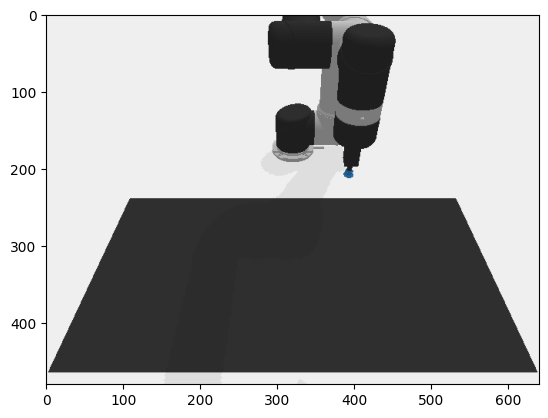

Lang Goal: place the red block in a brown bowl
new observation


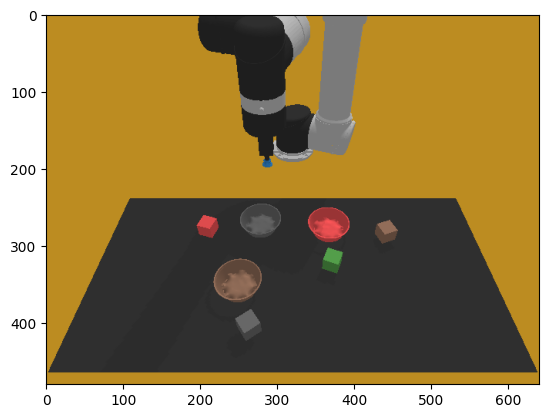

question: What colour block is in the brown bowl? ,vlm answer None
Put the red block in the brown bowl.
Lang Goal: place the brown block in a gray bowl
new observation


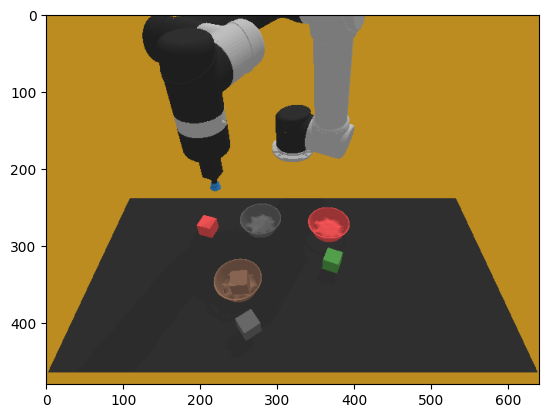

question: What colour block is in the gray bowl? ,vlm answer None
Put the brown block in the gray bowl.
Lang Goal: place the gray block in a red bowl
new observation


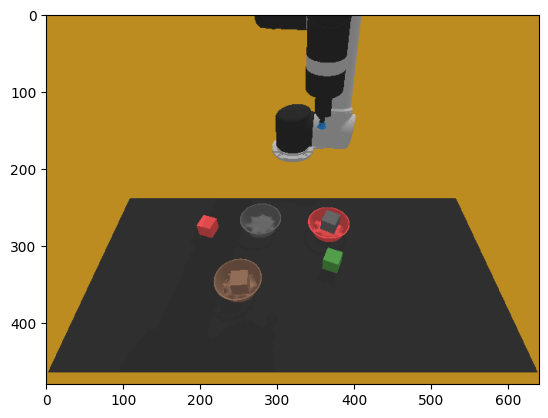

question: What colour block is in the red bowl? ,vlm answer None
Put the gray block in the red bowl.
No mismatched colored bowl found for the green block.
Plan Completed.


In [111]:

# List to track executed control actions
executed_actions = []
def validate_previous_actions():
    invalid_actions = []
    for index, action in enumerate(executed_actions):
        if action['type'] == 'put_first_inside_second':
            obj_a = action['obj_a']
            obj_b = action['obj_b']
            current_obj_inside = find_object_related_to_obj('inside', obj_b)
            print(f"current_obj_inside {obj_b}:", current_obj_inside , "target object: " , obj_a, str(current_obj_inside) in obj_a)

#             if obj_a.split(" ")[0] == "yellow":
#                 obj_a = [obj_a.split(" ")[0] , "brown"]

            if obj_a.split(" ")[0] == "blue":
                obj_a = [obj_a.split(" ")[0] , "gray"]
                
            if str(current_obj_inside) not in obj_a:
                invalid_actions.append((index, action))
                
            
    return invalid_actions

objects = random.sample(total_block , random.randint(2,4)) + random.sample(total_bowl , random.randint(2,4))
robot.objects = objects

# Get all objects on table
objects = get_object_names()
# Filter out the blocks and bowls
blocks = [obj for obj in objects if 'block' in obj]
bowls = [obj for obj in objects if 'bowl' in obj]
# Function to find a mismatched colored bowl for a given block

robot.reset()
executed_actions = []


def find_mismatched_bowl(block_color, remaining_bowls):
    for bowl in remaining_bowls:
        bowl_color = bowl.split(' ')[0]
        if block_color != bowl_color:
            return bowl
    return None

# Iterate through each block and find a mismatched colored bowl
for block in blocks:
    block_color = block.split(' ')[0]
    mismatched_bowl = find_mismatched_bowl(block_color, bowls)
    while True:
        # Check if previous actions are still valid
#         invalid_actions = validate_current_actions()
#         if not invalid_actions:
            # If a mismatched colored bowl is found, put the block in the bowl
        if mismatched_bowl is not None:
            put_first_on_second(block, mismatched_bowl)
            executed_actions.append({
                'type': 'put_first_inside_second',
                'obj_a': block,
                'obj_b': mismatched_bowl
            })
            print(f"Put the {block} in the {mismatched_bowl}.")
            # Remove the bowl from the list of available bowls
            bowls.remove(mismatched_bowl)
        else:
            tell_planner(f"No mismatched colored bowl found for the {block}.")
        break
#         else:
#             for index, invalid_action in invalid_actions:
#                 tell_planner(f"Validation failed. Action {index}: {invalid_action['type']}({invalid_action['obj_a']}, {invalid_action['obj_b']}) is no longer valid. Redoing the action.")
#                 # Redo the invalid action
#                 put_first_on_second(invalid_action['obj_a'], invalid_action['obj_b'])
tell_planner("Plan Completed.")